In [38]:
# ======================================
# Snippet 1: Data Loading + MFCC Features + Basic Missing Data Analysis
# ======================================

# -----------------------------
# IMPORTS
# -----------------------------
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


print("🚀 Loading competition data... / Competition data load kar rahe hain...")

# -----------------------------
# DATA LOADING
# -----------------------------
train_csv = "/kaggle/input/airs-ai-in-respiratory-sounds/train.csv"
audio_path = "/kaggle/input/airs-ai-in-respiratory-sounds/sounds/sounds"

train_df = pd.read_csv(train_csv)
print(f"✅ Training data loaded: {train_df.shape} / Training data ka size")

# -----------------------------
# TABULAR FEATURES
# -----------------------------
tab_features = ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 'phlegmCough',
                'familyAsthmaHistory', 'feverHistory', 'coldPresent', 'packYears']

# -----------------------------
# AUDIO FILE MAPPING
# -----------------------------
file_map = {}
for folder in os.listdir(audio_path):
    fpath = os.path.join(audio_path, folder)
    if os.path.isdir(fpath):
        wavs = [f for f in os.listdir(fpath) if f.endswith(".wav")]
        if wavs:
            file_map[folder] = os.path.join(fpath, wavs[0])

print(f"✅ Audio files mapped: {len(file_map)} / Total audio files mapped")

# -----------------------------
# MFCC FEATURE EXTRACTION FUNCTION
# -----------------------------
def extract_mfcc_features(file_path, n_mfcc=40, duration=5, sr=22050):
    """Extract MFCC + chroma + mel features / MFCC aur extra features extract karte hain"""
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)

        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_scaled = np.mean(chroma.T, axis=0)

        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_scaled = np.mean(mel.T, axis=0)

        features = np.hstack([mfcc_scaled, chroma_scaled, mel_scaled])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(n_mfcc + 12 + 128)  # Fallback

print("🎵 Extracting MFCC features for all audio files...")

X_audio = []
valid_ids = []
for i, cid in enumerate(train_df['candidateID']):
    if cid in file_map:
        features = extract_mfcc_features(file_map[cid])
        X_audio.append(features)
        valid_ids.append(cid)
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} files... / {i+1} files process ho chuki hain")

X_audio = np.array(X_audio)

# -----------------------------
# FILTER TABULAR & TARGET DATA
# -----------------------------
df = train_df[train_df['candidateID'].isin(valid_ids)]
X_tab = df[tab_features].values
y = df['disease'].values

print(f"✅ MFCC features shape: {X_audio.shape}")
print(f"✅ Dataset size after filtering: {len(df)}")
print(f"✅ Unique classes: {len(np.unique(y))}")

# -----------------------------
# BASIC MISSING DATA ANALYSIS
# -----------------------------
missing_data = df[tab_features].isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Feature': tab_features,
    'Missing_Count': missing_data,
    'Missing_Percent': missing_percent
})
print("\n🔍 Basic Missing Data Analysis / Missing data summary")
print(missing_summary)

🚀 Loading competition data... / Competition data load kar rahe hain...
✅ Training data loaded: (546, 11) / Training data ka size
✅ Audio files mapped: 882 / Total audio files mapped
🎵 Extracting MFCC features for all audio files...
Processed 100 files... / 100 files process ho chuki hain
Processed 200 files... / 200 files process ho chuki hain
Processed 300 files... / 300 files process ho chuki hain
Processed 400 files... / 400 files process ho chuki hain


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Processed 500 files... / 500 files process ho chuki hain
✅ MFCC features shape: (546, 180)
✅ Dataset size after filtering: 546
✅ Unique classes: 3

🔍 Basic Missing Data Analysis / Missing data summary
                                 Feature  Missing_Count  Missing_Percent
age                                  age              0         0.000000
gender                            gender              0         0.000000
tbContactHistory        tbContactHistory              0         0.000000
wheezingHistory          wheezingHistory              0         0.000000
phlegmCough                  phlegmCough              0         0.000000
familyAsthmaHistory  familyAsthmaHistory              0         0.000000
feverHistory                feverHistory              0         0.000000
coldPresent                  coldPresent            148        27.106227
packYears                      packYears              0         0.000000


In [39]:
# ======================================
# Snippet 2: Advanced Imputation (Iterative) + Tabular Preprocessing + Scaling
# ======================================

print("🔄 Applying Iterative Imputation (MICE) / Iterative imputation apply kar rahe hain...")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Original tabular data
X_tab_original = X_tab.copy()
y_original = y.copy()

# -----------------------------
# 1️⃣ Iterative Imputation (MICE) for all missing values
# -----------------------------
iterative_imputer = IterativeImputer(
    max_iter=10,
    random_state=42,
    estimator=RandomForestClassifier(n_estimators=50, random_state=42)
)

X_tab_iterative = iterative_imputer.fit_transform(X_tab_original)
print("✅ Iterative imputation applied / Iterative imputation complete")

# -----------------------------
# 2️⃣ Select Iterative Imputation as final dataset
# -----------------------------
X_tab_best = X_tab_iterative
print("✅ Using Iterative Imputation for final dataset / Iterative imputation final dataset ke liye select kiya")

# -----------------------------
# 3️⃣ Scale Tabular Features
# -----------------------------
scaler_tab = StandardScaler()
X_tab_scaled = scaler_tab.fit_transform(X_tab_best)
print("✅ Tabular features scaled / Tabular features scaling complete")


🔄 Applying Iterative Imputation (MICE) / Iterative imputation apply kar rahe hain...
✅ Iterative imputation applied / Iterative imputation complete
✅ Using Iterative Imputation for final dataset / Iterative imputation final dataset ke liye select kiya
✅ Tabular features scaled / Tabular features scaling complete


In [40]:
# ======================================
# Snippet 3: Train-Validation Split + MFCC reshaping + Class Weights
# ======================================

print("🚀 Creating train-validation split / Train-validation split bana rahe hain...")

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Filter to cases with available audio data
valid_indices = [i for i, cid in enumerate(train_df["candidateID"]) if cid in file_map]

X_tab_final_scaled = X_tab_scaled[valid_indices]  # Tabular features
X_audio_final = X_audio[valid_indices]           # MFCC / Audio features
y_final = y_original[valid_indices]              # Target labels

print(f"✅ Final dataset: {len(X_tab_final_scaled)} samples / Final dataset samples count")

# -----------------------------
# 1️⃣ Train-Validation Split
# -----------------------------
X_tab_train, X_tab_val, X_audio_train, X_audio_val, y_train, y_val = train_test_split(
    X_tab_final_scaled, X_audio_final, y_final,
    test_size=0.15,
    stratify=y_final,
    random_state=42
)

print("✅ Train-validation split done / Train-validation split complete")

# -----------------------------
# 2️⃣ Reshape Audio for CNN Input
# -----------------------------
X_audio_train = X_audio_train.reshape(X_audio_train.shape[0], X_audio_train.shape[1], 1)
X_audio_val = X_audio_val.reshape(X_audio_val.shape[0], X_audio_val.shape[1], 1)

print(f"Audio train shape: {X_audio_train.shape} / Audio validation shape: {X_audio_val.shape}")

# -----------------------------
# 3️⃣ Compute Class Weights for Imbalanced Data
# -----------------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print(f"✅ Class weights computed / Class weights: {class_weight_dict}")


🚀 Creating train-validation split / Train-validation split bana rahe hain...
✅ Final dataset: 546 samples / Final dataset samples count
✅ Train-validation split done / Train-validation split complete
Audio train shape: (464, 180, 1) / Audio validation shape: (82, 180, 1)
✅ Class weights computed / Class weights: {0: 1.2997198879551821, 1: 0.7656765676567657, 2: 1.0815850815850816}


In [41]:
# Advanced augmentation for 1D flattened MFCC/Mel
def advanced_flat_augmentation(feature_vector):
    augmented = feature_vector.copy()
    
    # Random noise
    if np.random.random() > 0.5:
        noise = np.random.normal(0, 0.01, augmented.shape)
        augmented += noise
    
    # Random shift
    if np.random.random() > 0.5:
        shift = np.random.randint(-5, 5)
        augmented = np.roll(augmented, shift)
    
    return augmented

# Augmented dataset
X_mel_augmented = []
X_tab_augmented = []
y_augmented = []

# Original data
X_mel_augmented.extend(X_mel_2d)
X_tab_augmented.extend(X_tab_mel)
y_augmented.extend(y_mel)

# Augmented data (3x augmentation)
for i in range(len(X_mel_2d)):
    for _ in range(3):
        aug_mel = advanced_flat_augmentation(X_mel_2d[i])
        X_mel_augmented.append(aug_mel)
        X_tab_augmented.append(X_tab_mel[i])
        y_augmented.append(y_mel[i])

X_mel_augmented = np.array(X_mel_augmented)
X_tab_augmented = np.array(X_tab_augmented)
y_augmented = np.array(y_augmented)

print(f"✅ Augmented dataset: {len(X_mel_augmented)} samples (original: {len(X_mel_2d)})")


✅ Augmented dataset: 1856 samples (original: 464)


In [42]:
# ======================================
# 3️⃣4.5️⃣ SPLIT AUGMENTED DATA
# ======================================

print("📊 Splitting augmented dataset into train and validation / Train aur val split kar rahe hain...")

from sklearn.model_selection import train_test_split

X_tab_aug_train, X_tab_aug_val, X_mel_aug_train, X_mel_aug_val, y_aug_train, y_aug_val = train_test_split(
    X_tab_augmented, X_mel_augmented, y_augmented,
    test_size=0.15, stratify=y_augmented, random_state=42
)

print(f"✅ Train set: {len(X_tab_aug_train)} samples, Validation set: {len(X_tab_aug_val)} samples")


📊 Splitting augmented dataset into train and validation / Train aur val split kar rahe hain...
✅ Train set: 1577 samples, Validation set: 279 samples


In [43]:
# ======================================
# 3️⃣5️⃣ FIXED SUPER ADVANCED MODEL
# ======================================

import tensorflow as tf
from tensorflow.keras import layers, Model

print("🔄 Creating Fixed Super Advanced Model / Super advanced model create kar rahe hain...")
num_classes = 3

def create_fixed_super_advanced_model(tabular_dim, pretrained_dim, num_classes):
    """Fixed super advanced model for 90%+ accuracy"""
    
    # Pre-trained features input
    pretrained_input = tf.keras.Input(shape=(pretrained_dim,), name='pretrained_features')
    
    x_pretrained = layers.Dense(1024, activation='relu')(pretrained_input)
    x_pretrained = layers.BatchNormalization()(x_pretrained)
    x_pretrained = layers.Dropout(0.4)(x_pretrained)
    
    x_pretrained = layers.Dense(512, activation='relu')(x_pretrained)
    x_pretrained = layers.BatchNormalization()(x_pretrained)
    x_pretrained = layers.Dropout(0.3)(x_pretrained)
    
    x_pretrained = layers.Dense(256, activation='relu')(x_pretrained)
    x_pretrained = layers.BatchNormalization()(x_pretrained)
    x_pretrained = layers.Dropout(0.2)(x_pretrained)
    
    # Tabular input
    tabular_input = tf.keras.Input(shape=(tabular_dim,), name='tabular_input')
    
    x_tab = layers.Dense(256, activation='relu')(tabular_input)
    x_tab = layers.BatchNormalization()(x_tab)
    x_tab = layers.Dropout(0.3)(x_tab)
    
    x_tab = layers.Dense(128, activation='relu')(x_tab)
    x_tab = layers.BatchNormalization()(x_tab)
    x_tab = layers.Dropout(0.2)(x_tab)
    
    x_tab = layers.Dense(64, activation='relu')(x_tab)
    
    # Combine
    combined = layers.concatenate([x_pretrained, x_tab])
    
    # Advanced classification
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Residual block 1
    residual1 = layers.Dense(512, activation='relu')(x)
    residual1 = layers.BatchNormalization()(residual1)
    x = layers.add([x, residual1])
    x = layers.Dropout(0.4)(x)
    
    # Residual block 2
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    residual2 = layers.Dense(256, activation='relu')(x)
    residual2 = layers.BatchNormalization()(residual2)
    x = layers.add([x, residual2])
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(
        inputs=[tabular_input, pretrained_input],
        outputs=output,
        name='fixed_super_advanced_model'
    )
    
    return model

# ✅ Create model
super_model = create_fixed_super_advanced_model(
    tabular_dim=X_tab_aug_train.shape[1],
    pretrained_dim=X_mel_aug_train.shape[1],  # MFCC / flattened features
    num_classes=num_classes
)

super_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Fixed super advanced model created!")
super_model.summary()


🔄 Creating Fixed Super Advanced Model / Super advanced model create kar rahe hain...
✅ Fixed super advanced model created!


Model: "fixed_super_advanced_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pretrained_features │ (None, 180)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 1024)      │    185,344 │ pretrained_featu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_65[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 256)       │      2,560 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 512)       │    524,800 │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_68[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_66[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 128)       │     32,896 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 256)       │    131,328 │ dropout_46[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_69[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_67[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 64)        │      8,256 │ dropout_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 320)       │          0 │ dropout_47[0][0]

 Total params: 1,566,019 (5.97 MB)

 Trainable params: 1,558,339 (5.94 MB)

 Non-trainable params: 7,680 (30.00 KB)

In [44]:
# ======================================
# 3️⃣6️⃣ FIXED SUPER ADVANCED MODEL TRAINING WITH PCA REDUCED MFCC
# ======================================

print("🎯 Preparing data and training Fixed Super Advanced Model with PCA-reduced MFCC...")

from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# --- 1. Flatten MFCC / Mel-spectrograms ---
X_mel_aug_train_flat = X_mel_aug_train.reshape(X_mel_aug_train.shape[0], -1)
X_mel_aug_val_flat   = X_mel_aug_val.reshape(X_mel_aug_val.shape[0], -1)

# --- 2. Reduce dimensionality to 128 features using PCA ---
pca = PCA(n_components=128, random_state=42)
X_mel_aug_train_pca = pca.fit_transform(X_mel_aug_train_flat)
X_mel_aug_val_pca   = pca.transform(X_mel_aug_val_flat)

print(f"✅ MFCC features reduced: Train {X_mel_aug_train_pca.shape}, Val {X_mel_aug_val_pca.shape}")

# --- 3. Create super advanced model ---
super_model = create_fixed_super_advanced_model(
    tabular_dim=X_tab_aug_train.shape[1],
    pretrained_dim=128,  # Matches PCA output
    num_classes=num_classes
)

super_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Super advanced model created and compiled!")

# --- 4. Class weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_aug_train), y=y_aug_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"✅ Class weights: {class_weight_dict}")

# --- 5. Callbacks ---
enhanced_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=40,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=20,
        min_lr=1e-8,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'fixed_super_advanced_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# --- 6. Train the model ---
print("🚀 Training fixed super advanced model with PCA-reduced MFCC...")
super_history = super_model.fit(
    [X_tab_aug_train, X_mel_aug_train_pca],
    y_aug_train,
    batch_size=16,
    epochs=300,
    validation_data=([X_tab_aug_val, X_mel_aug_val_pca], y_aug_val),
    callbacks=enhanced_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("✅ Fixed super advanced training completed!")

# --- 7. Load best weights and evaluate ---
super_model.load_weights('fixed_super_advanced_model.h5')

super_pred = super_model.predict([X_tab_aug_val, X_mel_aug_val_pca], verbose=0)
super_accuracy = accuracy_score(y_aug_val, np.argmax(super_pred, axis=1))

print(f"\n🎯 FIXED SUPER ADVANCED MODEL ACCURACY: {super_accuracy:.4f}")

# --- 8. Performance check ---
previous_best = 0.8780
improvement = super_accuracy - previous_best

if super_accuracy >= 0.90:
    print(f"🎉 🎉 🎉 UNBELIEVABLE! 90%+ ACHIEVED! 🎉 🎉 🎉")
    print(f"🚀 BREAKTHROUGH! +{improvement:.4f} improvement!")
elif super_accuracy >= 0.88:
    print(f"🔥 EXCELLENT! {super_accuracy:.4f} accuracy!")
    print(f"💪 Very close to 90%!")
else:
    print(f"💪 Good progress: {super_accuracy:.4f}")


🎯 Preparing data and training Fixed Super Advanced Model with PCA-reduced MFCC...
✅ MFCC features reduced: Train (1577, 128), Val (279, 128)
✅ Super advanced model created and compiled!
✅ Class weights: {0: 1.301155115511551, 1: 0.7651625424551188, 2: 1.0816186556927299}
🚀 Training fixed super advanced model with PCA-reduced MFCC...
Epoch 1/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3740 - loss: 1.5097
Epoch 1: val_accuracy improved from -inf to 0.43728, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.3740 - loss: 1.5095 - val_accuracy: 0.4373 - val_loss: 1.1392 - learning_rate: 1.0000e-04
Epoch 2/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3755 - loss: 1.3449
Epoch 2: val_accuracy did not improve from 0.43728
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3756 - loss: 1.3449 - val_accuracy: 0.4373 - val_loss: 1.1513 - learning_rate: 1.0000e-04
Epoch 3/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4014 - loss: 1.2712
Epoch 3: val_accuracy improved from 0.43728 to 0.46237, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4010 - loss: 1.2713 - val_accuracy: 0.4624 - val_loss: 1.1281 - learning_rate: 1.0000e-04
Epoch 4/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4010 - loss: 1.2930
Epoch 4: val_accuracy improved from 0.46237 to 0.52688, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4015 - loss: 1.2909 - val_accuracy: 0.5269 - val_loss: 1.0635 - learning_rate: 1.0000e-04
Epoch 5/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3854 - loss: 1.2211
Epoch 5: val_accuracy improved from 0.52688 to 0.54122, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3857 - loss: 1.2206 - val_accuracy: 0.5412 - val_loss: 1.0138 - learning_rate: 1.0000e-04
Epoch 6/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4070 - loss: 1.2069
Epoch 6: val_accuracy improved from 0.54122 to 0.59498, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4078 - loss: 1.2057 - val_accuracy: 0.5950 - val_loss: 0.9892 - learning_rate: 1.0000e-04
Epoch 7/300
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4372 - loss: 1.1499
Epoch 7: val_accuracy did not improve from 0.59498
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4382 - loss: 1.1479 - val_accuracy: 0.5950 - val_loss: 0.9325 - learning_rate: 1.0000e-04
Epoch 8/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4912 - loss: 1.0529
Epoch 8: val_accuracy improved from 0.59498 to 0.62007, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4911 - loss: 1.0530 - val_accuracy: 0.6201 - val_loss: 0.8814 - learning_rate: 1.0000e-04
Epoch 9/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5192 - loss: 0.9997
Epoch 9: val_accuracy improved from 0.62007 to 0.63799, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5177 - loss: 0.9997 - val_accuracy: 0.6380 - val_loss: 0.8304 - learning_rate: 1.0000e-04
Epoch 10/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4978 - loss: 1.0039
Epoch 10: val_accuracy improved from 0.63799 to 0.65950, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4984 - loss: 1.0031 - val_accuracy: 0.6595 - val_loss: 0.7942 - learning_rate: 1.0000e-04
Epoch 11/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5131 - loss: 0.9700
Epoch 11: val_accuracy improved from 0.65950 to 0.67742, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5135 - loss: 0.9696 - val_accuracy: 0.6774 - val_loss: 0.7629 - learning_rate: 1.0000e-04
Epoch 12/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5333 - loss: 0.9261
Epoch 12: val_accuracy did not improve from 0.67742
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5334 - loss: 0.9260 - val_accuracy: 0.6667 - val_loss: 0.7547 - learning_rate: 1.0000e-04
Epoch 13/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5856 - loss: 0.8937
Epoch 13: val_accuracy improved from 0.67742 to 0.70968, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5852 - loss: 0.8938 - val_accuracy: 0.7097 - val_loss: 0.7223 - learning_rate: 1.0000e-04
Epoch 14/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5710 - loss: 0.8766
Epoch 14: val_accuracy improved from 0.70968 to 0.74552, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5713 - loss: 0.8771 - val_accuracy: 0.7455 - val_loss: 0.6754 - learning_rate: 1.0000e-04
Epoch 15/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6216 - loss: 0.8114
Epoch 15: val_accuracy improved from 0.74552 to 0.76344, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6210 - loss: 0.8143 - val_accuracy: 0.7634 - val_loss: 0.6515 - learning_rate: 1.0000e-04
Epoch 16/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6005 - loss: 0.8692
Epoch 16: val_accuracy improved from 0.76344 to 0.76703, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6015 - loss: 0.8679 - val_accuracy: 0.7670 - val_loss: 0.6288 - learning_rate: 1.0000e-04
Epoch 17/300
89/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6352 - loss: 0.8136
Epoch 17: val_accuracy improved from 0.76703 to 0.78853, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6383 - loss: 0.8113 - val_accuracy: 0.7885 - val_loss: 0.5997 - learning_rate: 1.0000e-04
Epoch 18/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6417 - loss: 0.8017
Epoch 18: val_accuracy improved from 0.78853 to 0.79211, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6434 - loss: 0.7996 - val_accuracy: 0.7921 - val_loss: 0.5867 - learning_rate: 1.0000e-04
Epoch 19/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6864 - loss: 0.7341
Epoch 19: val_accuracy improved from 0.79211 to 0.79928, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6863 - loss: 0.7356 - val_accuracy: 0.7993 - val_loss: 0.5682 - learning_rate: 1.0000e-04
Epoch 20/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6800 - loss: 0.7515
Epoch 20: val_accuracy improved from 0.79928 to 0.80645, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6805 - loss: 0.7500 - val_accuracy: 0.8065 - val_loss: 0.5495 - learning_rate: 1.0000e-04
Epoch 21/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7339 - loss: 0.7170
Epoch 21: val_accuracy did not improve from 0.80645
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7327 - loss: 0.7148 - val_accuracy: 0.8029 - val_loss: 0.5424 - learning_rate: 1.0000e-04
Epoch 22/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7028 - loss: 0.7251
Epoch 22: val_accuracy did not improve from 0.80645
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7024 - loss: 0.7248 - val_accuracy: 0.8029 - val_loss: 0.5292 - learning_rate: 1.0000e-04
Epoch 23/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7368 - loss: 0.6616
Epoch 23: val_accuracy did not improve from 0.80645
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7359 - loss: 0.6626 - val_accuracy: 0.8029 - val_loss: 0.5283 - learning_rate: 1.0000e-04
Epoch 24/300
8

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7281 - loss: 0.6674 - val_accuracy: 0.8208 - val_loss: 0.5075 - learning_rate: 1.0000e-04
Epoch 29/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7569 - loss: 0.6386
Epoch 29: val_accuracy did not improve from 0.82079
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7573 - loss: 0.6365 - val_accuracy: 0.8136 - val_loss: 0.5018 - learning_rate: 1.0000e-04
Epoch 30/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7698 - loss: 0.6072
Epoch 30: val_accuracy did not improve from 0.82079
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7691 - loss: 0.6082 - val_accuracy: 0.8208 - val_loss: 0.4947 - learning_rate: 1.0000e-04
Epoch 31/300
87/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7740 - loss: 0.5805
Epoch 31: val_accuracy did not improve from 0.82079
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7733 - loss: 0.5857 - val_accuracy: 0.8208 - val_loss: 0.4920 - learning_rate: 1.0000e-04
Epoch 32/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7451 - loss: 0.6456 - val_accuracy: 0.8244 - val_loss: 0.4885 - learning_rate: 1.0000e-04
Epoch 33/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7731 - loss: 0.5973
Epoch 33: val_accuracy improved from 0.82437 to 0.82796, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7730 - loss: 0.5972 - val_accuracy: 0.8280 - val_loss: 0.4777 - learning_rate: 1.0000e-04
Epoch 34/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7508 - loss: 0.6195
Epoch 34: val_accuracy did not improve from 0.82796
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7512 - loss: 0.6189 - val_accuracy: 0.8172 - val_loss: 0.4760 - learning_rate: 1.0000e-04
Epoch 35/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7943 - loss: 0.5607
Epoch 35: val_accuracy improved from 0.82796 to 0.83154, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7941 - loss: 0.5614 - val_accuracy: 0.8315 - val_loss: 0.4771 - learning_rate: 1.0000e-04
Epoch 36/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7667 - loss: 0.5696
Epoch 36: val_accuracy did not improve from 0.83154
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7672 - loss: 0.5691 - val_accuracy: 0.8244 - val_loss: 0.4690 - learning_rate: 1.0000e-04
Epoch 37/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7661 - loss: 0.5797
Epoch 37: val_accuracy did not improve from 0.83154
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7661 - loss: 0.5797 - val_accuracy: 0.8280 - val_loss: 0.4655 - learning_rate: 1.0000e-04
Epoch 38/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7835 - loss: 0.5847
Epoch 38: val_accuracy did not improve from 0.83154
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7836 - loss: 0.5846 - val_accuracy: 0.8280 - val_loss: 0.4673 - learning_rate: 1.0000e-04
Epoch 39/300
8

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7952 - loss: 0.5295 - val_accuracy: 0.8387 - val_loss: 0.4565 - learning_rate: 1.0000e-04
Epoch 45/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8020 - loss: 0.5227
Epoch 45: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8019 - loss: 0.5228 - val_accuracy: 0.8315 - val_loss: 0.4502 - learning_rate: 1.0000e-04
Epoch 46/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8054 - loss: 0.5330
Epoch 46: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8050 - loss: 0.5335 - val_accuracy: 0.8351 - val_loss: 0.4494 - learning_rate: 1.0000e-04
Epoch 47/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7903 - loss: 0.5479
Epoch 47: val_accuracy did not improve from 0.83871
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7906 - loss: 0.5472 - val_accuracy: 0.8387 - val_loss: 0.4521 - learning_rate: 1.0000e-04
Epoch 48/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8109 - loss: 0.5214 - val_accuracy: 0.8423 - val_loss: 0.4440 - learning_rate: 1.0000e-04
Epoch 51/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7998 - loss: 0.5293
Epoch 51: val_accuracy did not improve from 0.84229
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7999 - loss: 0.5292 - val_accuracy: 0.8387 - val_loss: 0.4428 - learning_rate: 1.0000e-04
Epoch 52/300
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7984 - loss: 0.5557
Epoch 52: val_accuracy did not improve from 0.84229
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7985 - loss: 0.5553 - val_accuracy: 0.8280 - val_loss: 0.4407 - learning_rate: 1.0000e-04
Epoch 53/300
87/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8241 - loss: 0.5083
Epoch 53: val_accuracy did not improve from 0.84229
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8218 - loss: 0.5112 - val_accuracy: 0.8387 - val_loss: 0.4353 - learning_rate: 1.0000e-04
Epoch 54/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8071 - loss: 0.5115 - val_accuracy: 0.8459 - val_loss: 0.4362 - learning_rate: 1.0000e-04
Epoch 55/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8115 - loss: 0.4681
Epoch 55: val_accuracy improved from 0.84588 to 0.84946, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8113 - loss: 0.4695 - val_accuracy: 0.8495 - val_loss: 0.4330 - learning_rate: 1.0000e-04
Epoch 56/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8028 - loss: 0.4882
Epoch 56: val_accuracy did not improve from 0.84946
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8030 - loss: 0.4889 - val_accuracy: 0.8459 - val_loss: 0.4339 - learning_rate: 1.0000e-04
Epoch 57/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7868 - loss: 0.5155
Epoch 57: val_accuracy improved from 0.84946 to 0.85305, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7874 - loss: 0.5143 - val_accuracy: 0.8530 - val_loss: 0.4316 - learning_rate: 1.0000e-04
Epoch 58/300
98/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8075 - loss: 0.4798
Epoch 58: val_accuracy did not improve from 0.85305
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8075 - loss: 0.4800 - val_accuracy: 0.8459 - val_loss: 0.4329 - learning_rate: 1.0000e-04
Epoch 59/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8148 - loss: 0.4784
Epoch 59: val_accuracy did not improve from 0.85305
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8146 - loss: 0.4790 - val_accuracy: 0.8351 - val_loss: 0.4347 - learning_rate: 1.0000e-04
Epoch 60/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7953 - loss: 0.5312
Epoch 60: val_accuracy did not improve from 0.85305
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7956 - loss: 0.5307 - val_accuracy: 0.8387 - val_loss: 0.4312 - learning_rate: 1.0000e-04
Epoch 61/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8201 - loss: 0.4929 - val_accuracy: 0.8566 - val_loss: 0.4136 - learning_rate: 1.0000e-04
Epoch 68/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8440 - loss: 0.4421
Epoch 68: val_accuracy did not improve from 0.85663
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8435 - loss: 0.4431 - val_accuracy: 0.8530 - val_loss: 0.4082 - learning_rate: 1.0000e-04
Epoch 69/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8145 - loss: 0.4458
Epoch 69: val_accuracy did not improve from 0.85663
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8149 - loss: 0.4459 - val_accuracy: 0.8495 - val_loss: 0.4082 - learning_rate: 1.0000e-04
Epoch 70/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8240 - loss: 0.4504
Epoch 70: val_accuracy did not improve from 0.85663
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8239 - loss: 0.4501 - val_accuracy: 0.8495 - val_loss: 0.4034 - learning_rate: 1.0000e-04
Epoch 71/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8416 - loss: 0.3939 - val_accuracy: 0.8638 - val_loss: 0.3649 - learning_rate: 1.0000e-04
Epoch 83/300
94/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8455 - loss: 0.3932
Epoch 83: val_accuracy did not improve from 0.86380
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8457 - loss: 0.3940 - val_accuracy: 0.8459 - val_loss: 0.3638 - learning_rate: 1.0000e-04
Epoch 84/300
95/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8239 - loss: 0.4092
Epoch 84: val_accuracy did not improve from 0.86380
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8237 - loss: 0.4099 - val_accuracy: 0.8459 - val_loss: 0.3610 - learning_rate: 1.0000e-04
Epoch 85/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8235 - loss: 0.4375
Epoch 85: val_accuracy did not improve from 0.86380
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8239 - loss: 0.4368 - val_accuracy: 0.8495 - val_loss: 0.3557 - learning_rate: 1.0000e-04
Epoch 86/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8448 - loss: 0.3750 - val_accuracy: 0.8746 - val_loss: 0.3499 - learning_rate: 1.0000e-04
Epoch 89/300
96/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8474 - loss: 0.3676
Epoch 89: val_accuracy did not improve from 0.87455
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8479 - loss: 0.3670 - val_accuracy: 0.8710 - val_loss: 0.3469 - learning_rate: 1.0000e-04
Epoch 90/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8553 - loss: 0.3655
Epoch 90: val_accuracy did not improve from 0.87455
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8553 - loss: 0.3657 - val_accuracy: 0.8746 - val_loss: 0.3469 - learning_rate: 1.0000e-04
Epoch 91/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8465 - loss: 0.3926
Epoch 91: val_accuracy did not improve from 0.87455
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8466 - loss: 0.3926 - val_accuracy: 0.8674 - val_loss: 0.3395 - learning_rate: 1.0000e-04
Epoch 92/300
9

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8328 - loss: 0.3898 - val_accuracy: 0.8817 - val_loss: 0.3305 - learning_rate: 1.0000e-04
Epoch 96/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8544 - loss: 0.3804
Epoch 96: val_accuracy did not improve from 0.88172
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8536 - loss: 0.3803 - val_accuracy: 0.8602 - val_loss: 0.3341 - learning_rate: 1.0000e-04
Epoch 97/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8567 - loss: 0.3379
Epoch 97: val_accuracy did not improve from 0.88172
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8565 - loss: 0.3392 - val_accuracy: 0.8674 - val_loss: 0.3350 - learning_rate: 1.0000e-04
Epoch 98/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8633 - loss: 0.3538
Epoch 98: val_accuracy improved from 0.88172 to 0.88530, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8631 - loss: 0.3549 - val_accuracy: 0.8853 - val_loss: 0.3251 - learning_rate: 1.0000e-04
Epoch 99/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8410 - loss: 0.3802
Epoch 99: val_accuracy did not improve from 0.88530
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8424 - loss: 0.3800 - val_accuracy: 0.8710 - val_loss: 0.3237 - learning_rate: 1.0000e-04
Epoch 100/300
97/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8469 - loss: 0.3718
Epoch 100: val_accuracy did not improve from 0.88530
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8469 - loss: 0.3717 - val_accuracy: 0.8674 - val_loss: 0.3199 - learning_rate: 1.0000e-04
Epoch 101/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8463 - loss: 0.3875
Epoch 101: val_accuracy did not improve from 0.88530
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8469 - loss: 0.3857 - val_accuracy: 0.8746 - val_loss: 0.3206 - learning_rate: 1.0000e-04
Epoch 102/

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8275 - loss: 0.3968 - val_accuracy: 0.8889 - val_loss: 0.3121 - learning_rate: 1.0000e-04
Epoch 106/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8766 - loss: 0.3348
Epoch 106: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8752 - loss: 0.3359 - val_accuracy: 0.8817 - val_loss: 0.3138 - learning_rate: 1.0000e-04
Epoch 107/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8625 - loss: 0.3501
Epoch 107: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8630 - loss: 0.3489 - val_accuracy: 0.8817 - val_loss: 0.3126 - learning_rate: 1.0000e-04
Epoch 108/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8663 - loss: 0.3499
Epoch 108: val_accuracy did not improve from 0.88889
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8667 - loss: 0.3499 - val_accuracy: 0.8746 - val_loss: 0.3110 - learning_rate: 1.0000e-04
Epoch 10

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8707 - loss: 0.3113 - val_accuracy: 0.8961 - val_loss: 0.3009 - learning_rate: 1.0000e-04
Epoch 112/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8703 - loss: 0.3215
Epoch 112: val_accuracy did not improve from 0.89606
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8702 - loss: 0.3218 - val_accuracy: 0.8889 - val_loss: 0.3042 - learning_rate: 1.0000e-04
Epoch 113/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8831 - loss: 0.2995
Epoch 113: val_accuracy did not improve from 0.89606
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8827 - loss: 0.3006 - val_accuracy: 0.8925 - val_loss: 0.2921 - learning_rate: 1.0000e-04
Epoch 114/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8749 - loss: 0.3028
Epoch 114: val_accuracy did not improve from 0.89606
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8753 - loss: 0.3033 - val_accuracy: 0.8925 - val_loss: 0.3004 - learning_rate: 1.0000e-04
Epoch 11

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8718 - loss: 0.3338 - val_accuracy: 0.8996 - val_loss: 0.2939 - learning_rate: 1.0000e-04
Epoch 116/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8715 - loss: 0.2934
Epoch 116: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8718 - loss: 0.2945 - val_accuracy: 0.8996 - val_loss: 0.2869 - learning_rate: 1.0000e-04
Epoch 117/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8596 - loss: 0.3372
Epoch 117: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8605 - loss: 0.3357 - val_accuracy: 0.8853 - val_loss: 0.3022 - learning_rate: 1.0000e-04
Epoch 118/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8448 - loss: 0.4235
Epoch 118: val_accuracy did not improve from 0.89964
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8461 - loss: 0.4179 - val_accuracy: 0.8889 - val_loss: 0.2976 - learning_rate: 1.0000e-04
Epoch 11

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8854 - loss: 0.2614 - val_accuracy: 0.9032 - val_loss: 0.2820 - learning_rate: 1.0000e-04
Epoch 133/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8977 - loss: 0.2909
Epoch 133: val_accuracy did not improve from 0.90323
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8972 - loss: 0.2916 - val_accuracy: 0.8996 - val_loss: 0.2797 - learning_rate: 1.0000e-04
Epoch 134/300
90/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8701 - loss: 0.2978
Epoch 134: val_accuracy improved from 0.90323 to 0.90681, saving model to fixed_super_advanced_model.h5


99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8708 - loss: 0.2972 - val_accuracy: 0.9068 - val_loss: 0.2795 - learning_rate: 1.0000e-04
Epoch 135/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8906 - loss: 0.2907
Epoch 135: val_accuracy did not improve from 0.90681
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8910 - loss: 0.2898 - val_accuracy: 0.8996 - val_loss: 0.2768 - learning_rate: 1.0000e-04
Epoch 136/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9092 - loss: 0.2644
Epoch 136: val_accuracy did not improve from 0.90681
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9074 - loss: 0.2673 - val_accuracy: 0.8996 - val_loss: 0.2699 - learning_rate: 1.0000e-04
Epoch 137/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8918 - loss: 0.2611
Epoch 137: val_accuracy did not improve from 0.90681
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8922 - loss: 0.2605 - val_accuracy: 0.9068 - val_loss: 0.2785 - learning_rate: 1.0000e-04
Epoch 13

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8910 - loss: 0.2537 - val_accuracy: 0.9104 - val_loss: 0.2643 - learning_rate: 1.0000e-04
Epoch 140/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8962 - loss: 0.2692
Epoch 140: val_accuracy did not improve from 0.91039
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8956 - loss: 0.2698 - val_accuracy: 0.9032 - val_loss: 0.2662 - learning_rate: 1.0000e-04
Epoch 141/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8860 - loss: 0.2786
Epoch 141: val_accuracy did not improve from 0.91039
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8864 - loss: 0.2777 - val_accuracy: 0.9032 - val_loss: 0.2679 - learning_rate: 1.0000e-04
Epoch 142/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8808 - loss: 0.2799
Epoch 142: val_accuracy did not improve from 0.91039
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8812 - loss: 0.2795 - val_accuracy: 0.9032 - val_loss: 0.2766 - learning_rate: 1.0000e-04
Epoch 14

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9132 - loss: 0.2287 - val_accuracy: 0.9140 - val_loss: 0.2742 - learning_rate: 1.0000e-04
Epoch 152/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9175 - loss: 0.2233
Epoch 152: val_accuracy did not improve from 0.91398
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9170 - loss: 0.2249 - val_accuracy: 0.8925 - val_loss: 0.2758 - learning_rate: 1.0000e-04
Epoch 153/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9047 - loss: 0.2306
Epoch 153: val_accuracy did not improve from 0.91398
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9045 - loss: 0.2309 - val_accuracy: 0.9104 - val_loss: 0.2840 - learning_rate: 1.0000e-04
Epoch 154/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9065 - loss: 0.2525
Epoch 154: val_accuracy did not improve from 0.91398
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9071 - loss: 0.2505 - val_accuracy: 0.9032 - val_loss: 0.2911 - learning_rate: 1.0000e-04
Epoch 15

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9177 - loss: 0.2101 - val_accuracy: 0.9211 - val_loss: 0.2547 - learning_rate: 1.0000e-04
Epoch 171/300
91/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9033 - loss: 0.2528
Epoch 171: val_accuracy did not improve from 0.92115
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9039 - loss: 0.2502 - val_accuracy: 0.9032 - val_loss: 0.2531 - learning_rate: 1.0000e-04
Epoch 172/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9058 - loss: 0.2480
Epoch 172: val_accuracy did not improve from 0.92115
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9069 - loss: 0.2460 - val_accuracy: 0.9104 - val_loss: 0.2599 - learning_rate: 1.0000e-04
Epoch 173/300
92/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9094 - loss: 0.2166
Epoch 173: val_accuracy did not improve from 0.92115
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9092 - loss: 0.2169 - val_accuracy: 0.9104 - val_loss: 0.2585 - learning_rate: 1.0000e-04
Epoch 17

📊 Evaluating Super Advanced Model...


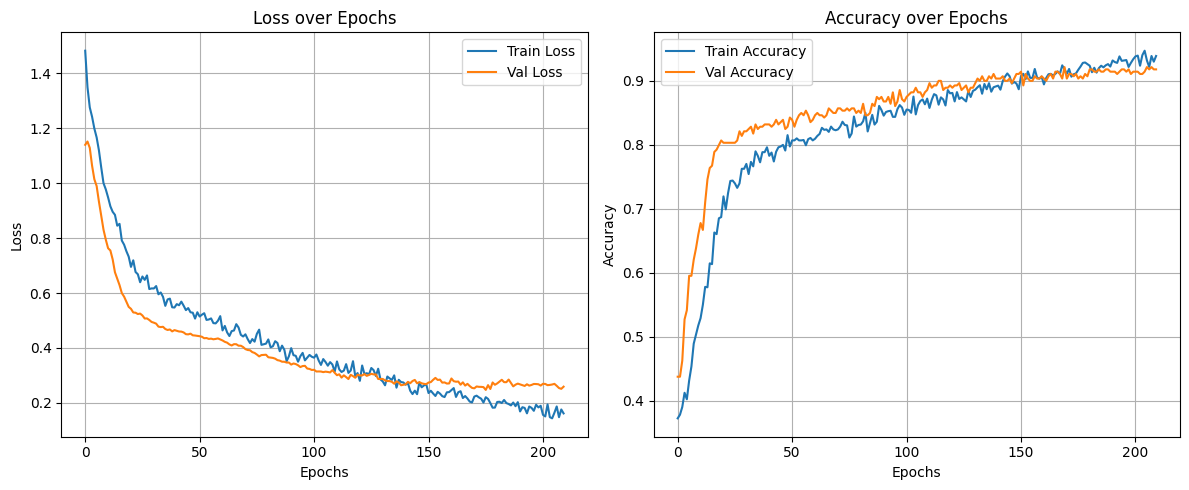

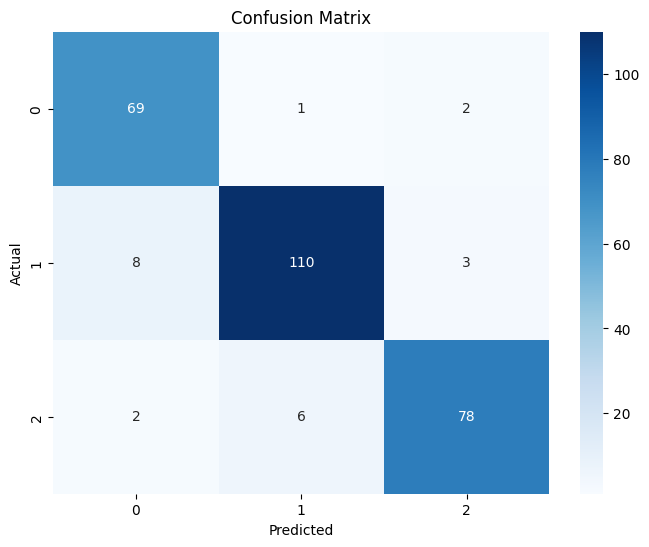

📄 Classification Report:

              precision    recall  f1-score   support

           0     0.8734    0.9583    0.9139        72
           1     0.9402    0.9091    0.9244       121
           2     0.9398    0.9070    0.9231        86

    accuracy                         0.9211       279
   macro avg     0.9178    0.9248    0.9205       279
weighted avg     0.9228    0.9211    0.9213       279


🎯 Overall Validation Accuracy: 0.9211


In [45]:
# ======================================
# 3️⃣7️⃣ MODEL EVALUATION & METRICS
# ======================================


print("📊 Evaluating Super Advanced Model...")

# --- 1. Training history plots ---
history = super_history.history

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 2. Predictions on validation set ---
y_val_pred_probs = super_model.predict([X_tab_aug_val, X_mel_aug_val_pca], verbose=0)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# --- 3. Confusion Matrix ---
cm = confusion_matrix(y_aug_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- 4. Classification Report ---
report = classification_report(y_aug_val, y_val_pred, digits=4)
print("📄 Classification Report:\n")
print(report)

# --- 5. Overall accuracy ---
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_aug_val, y_val_pred)
print(f"\n🎯 Overall Validation Accuracy: {accuracy:.4f}")
